In [15]:
import os
import comtypes.client
import zeep
import pandas as pd
# import matplotlib as plt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import io
from PIL import Image
import xlsxwriter
import io
from PIL import Image
import xlsxwriter
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def excel_to_pdf(infile=None, outfile=None):
    cwd = os.getcwd()
    infile = os.path.join(os.path.abspath(cwd), infile)
    outfile = os.path.join(os.path.abspath(cwd), outfile)
    # infile = "C:/Users/niejn/PycharmProjects/scrapy_demo/期货统计排名_交易所.xlsx"
    # outfile = "C:/Users/niejn/PycharmProjects/scrapy_demo/test5.pdf"
    app = comtypes.client.CreateObject('Excel.Application')
    app.Visible = False
    doc = app.Workbooks.Open(infile, ReadOnly=False)
    doc.ExportAsFixedFormat(0, outfile, 1, 0)
    doc.Close()
    app.Quit()
    comtypes.CoUninitialize()
    return

def getData(par_dict={"KSRQ": "2018-02-26", "JSRQ": "2018-02-26", "YYB": "1", "TJFL": "0"},
            lookout_str='cxSqlKHCJTJ_GPXZ'):
    wsdl = 'http://10.21.2.75:8080/service/LBEBusiness?wsdl'
    client = zeep.Client(wsdl=wsdl)
    # ns0:loginResult(message: xsd:string, result: xsd:int, sessionId: xsd:string)
    sessionId = client.service.login("ZXQH_GPXZ", "GPXZ123321", "myapp", "plain", "")
    # print(client.service.login("ZXQH_GPXZ", "GPXZ123321", "myapp", "plain", ""))
    factory = client.type_factory('ns0')
    string_type = client.get_type('xsd:string')
    lbParameter_type = client.get_type('ns0:lbParameter')
    queryOption_type = client.get_type('ns0:queryOption')
    '''		tmap.put("KSRQ", "2018-02-26");
    		tmap.put("JSRQ", "2018-02-26");
    		tmap.put("YYB", "1");
    		tmap.put("TJFL", "0");'''
    # par_dict = {"KSRQ": "2018-02-26", "JSRQ": "2018-02-26", "YYB": "1", "TJFL": "0"}
    params = []
    for key in par_dict:
        val = par_dict[key]
        temp_lbParameter = lbParameter_type(name=key, value=val)
        params.append(temp_lbParameter)

    valueOption_type = client.get_type('ns0:valueOption')
    valueOption = valueOption_type('VALUE')
    batchNo = 1
    batchSize = 3000
    ans_records = []
    mqueryOption = queryOption_type(batchNo=batchNo, batchSize=batchSize, queryCount=True, valueOption=valueOption)

    ans = client.service.query(sessionId.sessionId, lookout_str, params, "", mqueryOption)
    ans_records.extend(ans.records)

    while ((ans.result > 0) & ans.hasMore):
        batchNo += 1
        print('batchNo:{batchNo}'.format(batchNo=batchNo))

        mqueryOption = queryOption_type(batchNo=batchNo, batchSize=batchSize, queryCount=True, valueOption=valueOption)
        ans = client.service.query(sessionId.sessionId, lookout_str, params, "", mqueryOption)
        ans_records.extend(ans.records)
        # print(ans)
        print('batchNo:{batchNo}'.format(batchNo=batchNo))

    print(client.service.logout(sessionId.sessionId))
    return ans_records

def get_historydata():
    par_dict = {"KSRQ": "2018-01-01", "JSRQ": "2018-02-23", "ZB": "0", "ZQ": "0", "TJFL": "0"}
    lookout_str = 'SqlGPXZGSSCQS'

    records = getData(par_dict, lookout_str)
    # print(records)
    clean_records = []
    for a_record in records:
        clean_records.append(a_record.values)
    df = pd.DataFrame(clean_records, columns=['trade_type', 'time', 'sum', ])
    print(df.head())
    df['time'] = pd.to_datetime(df['time'])
    df['sum'] = df['sum'].astype(float)
    df['sum'] = df['sum'] / df['sum'].max()

    df_market = df[df['trade_type'] == '市场']
    df_corpor = df[df['trade_type'] != '市场']

    join_df = df_market.set_index('time').join(df_corpor.set_index('time'), lsuffix='_market', rsuffix='_corpor')
    # print(join_df['sum_market'])

    return


def get_historydata_exchange():
    par_dict = {"KSRQ": "2018-01-01", "JSRQ": "2018-02-23", "ZB": "0", "ZQ": "0", "TJFL": "0"}
    lookout_str = 'SqlGPXZGSSCQS'
    exchange_dict = {'1': '大连', '2': '上海', '3': '中金', '4': '郑州', }
    df_dict = {}
    for key in exchange_dict:
        par_dict['JYS'] = key
        records = getData(par_dict, lookout_str)
        # print(records)
        clean_records = []

        for a_record in records:
            clean_records.append(a_record.values)
        if not clean_records:
            return

        df = pd.DataFrame(clean_records, columns=['trade_type', 'time', 'sum', ])
        print(df.head())
        df['time'] = pd.to_datetime(df['time'])
        df['sum'] = df['sum'].astype(float)
        # df['sum'] = df['sum'] / df['sum'].max()

        df_market = df[df['trade_type'] == '市场']
        df_corpor = df[df['trade_type'] != '市场']

        join_df = df_market.set_index('time').join(df_corpor.set_index('time'), lsuffix='_market', rsuffix='_corpor')
        # print(join_df)
        # print(join_df['sum_market'])
        df_dict[exchange_dict[key]] = join_df
        print(join_df.head())
    return df_dict

def plot_to_excel(df_dict=None):
    
    img_list = []
    for key in df_dict:
        test_df = df_dict[key].copy()
        test_df = test_df.reset_index()
        plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
        plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
        fig, axes = plt.subplots(nrows=2, ncols=1, )
        fig.set_figheight(4)
        fig.set_figwidth(6)
        test_df['time'] = test_df['time'].apply(lambda x: x.strftime('%Y-%m-%d'))
        ax = test_df[['time', 'sum_corpor']].plot(
            x='time', linestyle='-', marker='o', ax=axes[0])
        ax2 = test_df[['time', 'sum_market']].plot(
            x='time', linestyle='-', marker='o', secondary_y=True, ax=axes[0])
        test_df[['time', 'sum_corpor', 'sum_market']].plot(x='time', kind='bar'

                                                           , logy=True
                                                           , sharex=True
                                                           , ax=axes[1])

        def currency(x, pos):
            'The two args are the value and tick position'
            if x >= 1000000:
                return '${:1.1f}M'.format(x * 1e-6)
            return '${:1.0f}K'.format(x * 1e-3)

        def percent(x, pos):
            return '%.2f%%' % (x * 100)

        formatter = FuncFormatter(percent)
        axes[0].yaxis.set_major_formatter(formatter)
        axes[0].legend(['中信期货市场占比', '市场成交量'])

        ax2.yaxis.set_major_formatter(formatter)
        axes[1].yaxis.set_major_formatter(formatter)
        fig.suptitle('{exchange}期货交易所成交市场占比'.format(exchange=key), fontsize=14, fontweight='bold');
        imgdata = BytesIO()
        fig.savefig(imgdata, format="png")
        imgdata.seek(0)
        img_list.append(imgdata)
    workbook = xlsxwriter.Workbook('期货持仓分析报告.xlsx')
    worksheet = workbook.add_worksheet("全市场成交统计")
    num = 5
    for img in img_list:
        # imgdata.seek(0)
        # use with xlsxwriter
        image_path = 'sales.png'
        bound_width_height = (240, 240)
        worksheet.insert_image('A{num}'.format(num=num), image_path, {'image_data': img, })
        # image_path = '{exchange}期货交易所成交市场占比.png'.format(exchange=key)
        # worksheet.insert_image('A{pos}'.format(pos=str(img_pos)), image_path, {'image_data': imgdata, })
        num += 30

    workbook.close()

    filename = "期货持仓分析报告"
    # excel_to_pdf('{filename}.xlsx'.format(filename=filename), '{filename}.pdf'.format(filename=filename))
    return

{
    'message': '成功',
    'result': 1
}
  trade_type      time    sum
0         公司  20180102  18175
1         市场  20180102  89762
2         公司  20180103  15883
3         市场  20180103  80229
4         公司  20180104  14544
           trade_type_market  sum_market trade_type_corpor  sum_corpor
time                                                                  
2018-01-02                市场     89762.0                公司     18175.0
2018-01-03                市场     80229.0                公司     15883.0
2018-01-04                市场     74620.0                公司     14544.0
2018-01-05                市场     60542.0                公司     11967.0
2018-01-08                市场     74336.0                公司     15347.0


{
    'message': '成功',
    'result': 1
}
  trade_type      time      sum
0         公司  20180102   285783
1         市场  20180102  7006530
2         公司  20180103   247007
3         市场  20180103  6493134
4         公司  20180104   275341
           trade_type_market  sum_market trade_type_corpor  sum_corpor
time                                                                  
2018-01-02                市场   7006530.0                公司    285783.0
2018-01-03                市场   6493134.0                公司    247007.0
2018-01-04                市场   7088142.0                公司    275341.0
2018-01-05                市场   8024484.0                公司    312775.0
2018-01-08                市场   7541482.0                公司    290708.0


{
    'message': '成功',
    'result': 1
}
  trade_type      time      sum
0         公司  20180102   291152
1         市场  20180102  6501486
2         市场  20180103  7112008
3         公司  20180103   292624
4         公司  20180104   326502
           trade_type_market  sum_market trade_type_corpor  sum_corpor
time                                                                  
2018-01-02                市场   6501486.0                公司    291152.0
2018-01-03                市场   7112008.0                公司    292624.0
2018-01-04                市场   8113074.0                公司    326502.0
2018-01-05                市场   8386462.0                公司    316237.0
2018-01-08                市场   8683398.0                公司    360057.0


{
    'message': '成功',
    'result': 1
}
  trade_type      time      sum
0         公司  20180102   130115
1         市场  20180102  3387024
2         市场  20180103  3381688
3         公司  20180103   103629
4         公司  20180104   144542
           trade_type_market  sum_market trade_type_corpor  sum_corpor
time                                                                  
2018-01-02                市场   3387024.0                公司    130115.0
2018-01-03                市场   3381688.0                公司    103629.0
2018-01-04                市场   4718176.0                公司    144542.0
2018-01-05                市场   3790508.0                公司    116830.0
2018-01-08                市场   4018464.0                公司    137122.0


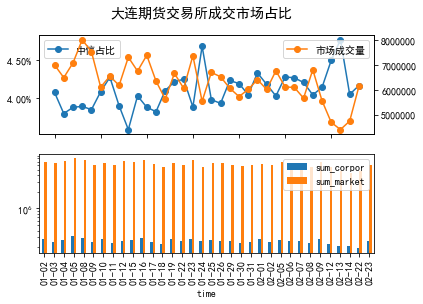

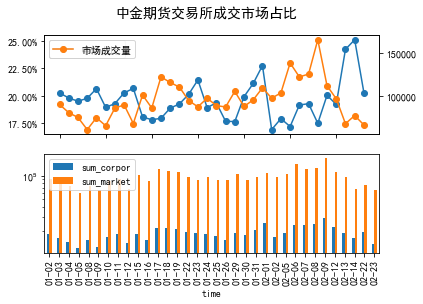

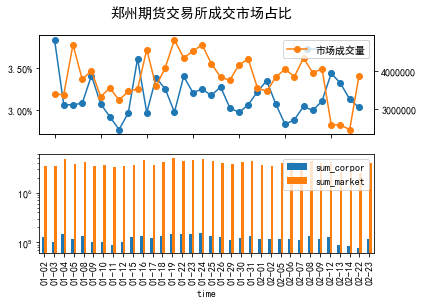

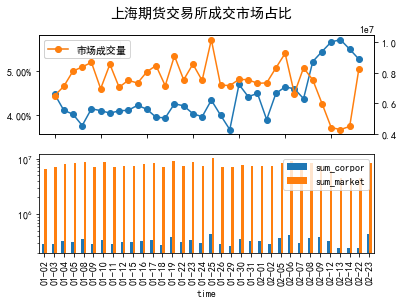

In [19]:
df_dict = get_historydata_exchange()
img_list = []
for key in df_dict:
    test_df = df_dict[key].copy()
    #  trade_type_market  sum_market trade_type_corpor  sum_corpor
    test_df['corpor_div_market'] = test_df['sum_corpor'] / test_df['sum_market']
    test_df = test_df.reset_index()
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
    fig, axes = plt.subplots(nrows=2, ncols=1, )
    fig.set_figheight(4)
    fig.set_figwidth(6)
    test_df['time'] = test_df['time'].apply(lambda x: x.strftime('%m-%d'))
    ax = test_df[['time', 'corpor_div_market']].plot(
        x='time', linestyle='-', marker='o', ax=axes[0])
    ax2 = test_df[['time', 'sum_market']].plot(
        x='time', linestyle='-', marker='o', secondary_y=True, ax=axes[0])
    test_df[['time', 'sum_corpor', 'sum_market']].plot(x='time', kind='bar'

                                                       , logy=True
                                                       , sharex=True
                                                       , ax=axes[1])

    def currency(x, pos):
        'The two args are the value and tick position'
        if x >= 1000000:
            return '${:1.1f}M'.format(x * 1e-6)
        return '${:1.0f}K'.format(x * 1e-3)

    def percent(x, pos):
        return '%.2f%%' % (x * 100)

    formatter = FuncFormatter(percent)
    axes[0].yaxis.set_major_formatter(formatter)
    ax.legend(['中信占比',])
    ax2.legend(['市场成交量'])
    # ax2.yaxis.set_major_formatter(formatter)
    # axes[1].yaxis.set_major_formatter(formatter)
    fig.suptitle('{exchange}期货交易所成交市场占比'.format(exchange=key), fontsize=14, fontweight='bold');
    imgdata = BytesIO()
    fig.savefig(imgdata, format="png")
    imgdata.seek(0)
    img_list.append(imgdata)
